In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
sys.path.append('../../matminer/')

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from pymatgen.core import Structure
from pymatgen.analysis.magnetism.analyzer import CollinearMagneticStructureAnalyzer
from pymatgen.analysis.magnetism.jahnteller import JahnTellerAnalyzer

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold,KFold


from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import r2_score,roc_auc_score,accuracy_score,roc_curve,auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
from tqdm.auto import tqdm




In [3]:
import  matminer.featurizers.structure as st
import matminer.featurizers.site  as site

from matminer.featurizers.conversions import StrToComposition

from matminer.featurizers.base import MultipleFeaturizer

from pymatgen.analysis.local_env import VoronoiNN


In [2]:
df=pd.read_json('../structure-mae-novamag-iastate/novamag-iastate-mae-ds.json')
df['formula']=[Structure.from_dict(x).reduced_formula for x in df['structures'].to_list()]
df['structures']=[Structure.from_dict(x) for x in df['structures'].to_list()]
# df['ferro_structures']=[CollinearMagneticStructureAnalyzer(x,overwrite_magmom_mode='replace_all')\
#     .get_ferromagnetic_structure(make_primitive=True) for x in df['structures'].to_list()]
# df['mag_struct_class']=[CollinearMagneticStructureAnalyzer(x,overwrite_magmom_mode='replace_all') for x in df['structures'].to_list()]
# df=StrToComposition().featurize_dataframe(df,'formula',ignore_errors=True)
df['uniaxial']=df['MAEs'].apply(lambda x:1 if x>0 else 0)

In [6]:
# for i in range(15):
#     df['species_'+str(i)]=-1

In [7]:
# for idx,row in df.iterrows():
#     eig_values=np.linalg.eig(row['ferro_structures'].distance_matrix).eigenvalues
#     eig_values=eig_values.real
#     len_arr=eig_values.size
    
#     if len_arr>15:
#         len_arr=15
#         eig_values=eig_values[:15]
    
#     df.loc[idx,['species_'+str(i) for i in range(len_arr)]]=eig_values
    
    

In [8]:
# for idx,row in df.iterrows():
#     mag_only_struct=row['mag_struct_class'].get_structure_with_only_magnetic_atoms()
    

#     for j,mag_species in enumerate(mag_only_struct.get_all_neighbors(r=4.0)):
#         distances=[]
#         main_site=mag_only_struct.sites[j]
#         for k,neighbor in enumerate(mag_species):
            
#             dist=main_site.distance(neighbor)
#             distances.append(dist)
    
#         arr=np.array(distances)
#         arr=arr[arr!=0]
#         if arr.size!=0:
            
#             uniques=np.unique(arr)
#             df.at[idx,'mag_species_'+str(j+1)+'_'+'std']=np.std(uniques)
#             df.at[idx,'mag_species_'+str(j+1)+'_'+'max']=np.max(uniques)
#             df.at[idx,'mag_species_'+str(j+1)+'_'+'min']=np.min(uniques)
#             df.at[idx,'mag_species_'+str(j+1)+'_'+'ave']=np.average(uniques)
        
#         if j==14:
#             break
        
    
    
    
    

In [9]:
# mag_only_struct=df['mag_struct_class'][2155].get_structure_with_only_magnetic_atoms()

In [10]:
# for j,mag_species in enumerate(mag_only_struct.get_all_neighbors(r=4.0)):
#     distances=[]
#     main_site=mag_only_struct.sites[j]
#     for k,neighbor in enumerate(mag_species):
        
#         dist=main_site.distance(neighbor)
#         distances.append(dist)  
#     break  

In [11]:
# df['num_mag_sites']=[x.number_of_magnetic_sites for x in df['mag_struct_class'].to_list()]
# df['num_uniq_mag_sites']=[x.number_of_unique_magnetic_sites() for x in df['mag_struct_class'].to_list()]
# df['num_nonuniq_mag_sites']=df['num_mag_sites']-df['num_uniq_mag_sites']

# df['num_uniq_mag_sites']=df['num_uniq_mag_sites']/df['num_mag_sites']
# df['num_nonuniq_mag_sites']=df['num_nonuniq_mag_sites']/df['num_mag_sites']
# df['magmom_density']=[sum(x.magmoms)/y.volume for x,y in zip(df['mag_struct_class'].to_list(),df['structures'].to_list())]


In [5]:


featurizers=MultipleFeaturizer(
    [
        # st.SiteStatsFingerprint.from_preset('ucar_local_prop_diff'),  #1;  1+2=0.632
        # st.SiteStatsFingerprint.from_preset('ucar_elemental_prop'), #2
        # st.SiteStatsFingerprint(site.BondOrientationalParameter()), #3,  1+2+3=0.637
        #st.SiteStatsFingerprint(site.AverageBondLength(method=VoronoiNN(),)) #4 #1+2+4=0.637
        #st.SiteStatsFingerprint(site.AverageBondAngle(method=VoronoiNN(),)) #5, #1+2+4=0.633
        
        
        st.SiteStatsFingerprint(site.AGNIFingerprints()), #6  alone =0.653, 1+2+6=0.637..
        st.SiteStatsFingerprint(site.OPSiteFingerprint()), #7, along=0.643  6+7=0.661
        # st.SiteStatsFingerprint(site.VoronoiFingerprint()), #10 alone =0.66, 6+7+10=0.67, 1+2+6+7+10=0.65
        st.OrbitalFieldMatrix(), #18, 0.635 , 6+7+10+18=0.677 after dropping 0 values in columns with .any()



        # st.SiteStatsFingerprint(site.CrystalNNFingerprint.from_preset('ops')), #8 alone =0.64 , 6+7+8=0.655
        #st.SiteStatsFingerprint(site.CrystalNNFingerprint.from_preset('cn')), #9 alone =0.627
        # st.SiteStatsFingerprint(site.IntersticeDistribution()) #11, 0.642, 6+7+10+11=0.675
        #st.SiteStatsFingerprint(site.GaussianSymmFunc()), #12 alone= 0.626
        #st.BondFractions.from_preset('VoronoiNN'), #12, 0.622
        #st.BagofBonds(), #13 took very long
        # st.StructuralHeterogeneity(), #14, 0.627, 6+7+10+14=0.659
        #st.MinimumRelativeDistances(), #15, 0.614
        
        #st.CoulombMatrix() #16, 0.62
        #st.SineCoulombMatrix(), #17, 0.634
        #st.XRDPowderPattern(), #19, 0.638, 6+7+10+19=0.663
        # st.RadialDistributionFunction() #20, 0.643, 6+7+10+20=0.666


        # st.GlobalSymmetryFeatures(),
        # st.DensityFeatures(),
        # st.ChemicalOrdering(),    #ALL basic ones= 0.652
        # st.MaximumPackingEfficiency(),
        # st.StructuralComplexity()
    ]
)

In [6]:
# df=featurizers.fit_featurize_dataframe(df,col_id='structures',ignore_errors=True)

In [7]:
# df=df.loc[:,df.any()]

In [15]:
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# splits=skf.split(df, df['uniaxial'])
    
# accs = []
# rocs=[]  
# for train_index,test_index in splits:
#     train,test=df.loc[train_index],df.loc[test_index]
#     train_features=train.drop(columns=['structures', 'MAEs', 'formula','uniaxial'])
#     test_features=test.drop(columns=['structures', 'MAEs', 'formula','uniaxial'])
    
#     train_target=train['uniaxial']
#     test_target=test['uniaxial']

#     random_regressor = RandomForestClassifier(
#     n_estimators=200, max_depth = 30, n_jobs=-1, random_state=0)
#     random_regressor.fit(train_features, train_target)
#     predictions = random_regressor.predict(test_features)
#     accuracy = accuracy_score(list(test_target), predictions)
#     roc=roc_auc_score(list(test_target), predictions)
#     print('accuracy is %.3f' % accuracy)
#     print('roc score is: %.3f' % roc)
    
#     accs.append(accuracy)
#     rocs.append(roc)

In [16]:
# np.mean(accs)

In [8]:
X=featurizers.featurize_many(df['structures'],ignore_errors=True)

MultipleFeaturizer:   3%|▎         | 70/2156 [00:00<00:03, 661.80it/s]/Users/huseyin.ucar/anaconda3/envs/matgl/lib/python3.9/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/huseyin.ucar/anaconda3/envs/matgl/lib/python3.9/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/huseyin.ucar/anaconda3/envs/matgl/lib/python3.9/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/huseyin.ucar/anaconda3/envs/matgl/lib/python3.9/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use

In [10]:
X = np.array(X)
print('Input data shape:', X.shape)

Input data shape: (2156, 1162)


In [11]:
X.dump(open('matminer_features_MAE.npy', 'wb'))


In [3]:
MAE_features = np.load(open('matminer_features_MAE.npy', 'rb'),allow_pickle=True)


In [13]:

import pandas as pd
failed = np.any(pd.isnull(X), axis=1)
print('Number failed: {}/{}'.format(np.sum(failed), len(failed)))

Number failed: 0/2156


In [4]:
model = Pipeline([
    ('imputer', SimpleImputer()), # For the failed structures
    ('model', RandomForestClassifier(n_estimators=200, max_depth = 20, n_jobs=-1, random_state=0))
])

In [6]:

accs = []
rocs=[]
progress_bar = tqdm(range(10))

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

splits=skf.split(df, df['uniaxial'])

for train_ids, test_ids in splits:
    # Split off the datasets
    train_X = MAE_features[train_ids, :]
    train_y = df['uniaxial'].iloc[train_ids]
    test_X = MAE_features[test_ids, :]
    test_y = df['uniaxial'].iloc[test_ids]
    
    # Train the model
    model.fit(train_X, train_y)
    
    # Run the model, compute MAE
    predict_y = model.predict(test_X)
    accuracy = accuracy_score(list(test_y), predict_y)
    roc=roc_auc_score(list(test_y), predict_y)
    print('accuracy is %.3f' % accuracy)
    print('roc score is: %.3f' % roc)
    
    accs.append(accuracy)
    rocs.append(roc)
    


  0%|          | 0/10 [00:33<?, ?it/s]


accuracy is 0.681
roc score is: 0.680
accuracy is 0.681
roc score is: 0.681
accuracy is 0.616
roc score is: 0.617
accuracy is 0.694
roc score is: 0.695
accuracy is 0.681
roc score is: 0.681
accuracy is 0.704
roc score is: 0.704
accuracy is 0.684
roc score is: 0.685
accuracy is 0.591
roc score is: 0.593
accuracy is 0.651
roc score is: 0.651
accuracy is 0.693
roc score is: 0.693


In [16]:
np.mean(accs)

0.6669465977605513

In [7]:
cm = confusion_matrix(test_y, predict_y, labels=model.classes_)


In [9]:
import matplotlib.pyplot as plt
import numpy as np



# Set global font properties
plt.rcParams.update({
    'font.family': 'Arial',
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'axes.titlesize': 36,
    'axes.labelsize': 36,
    'legend.fontsize': 36,
})
%matplotlib inline
%config InlineBackend.figure_format ='retina'

In [15]:
title_size = 16
plt.rcParams.update({'font.size':16})
colorbar = False
cmap = "Blues" 


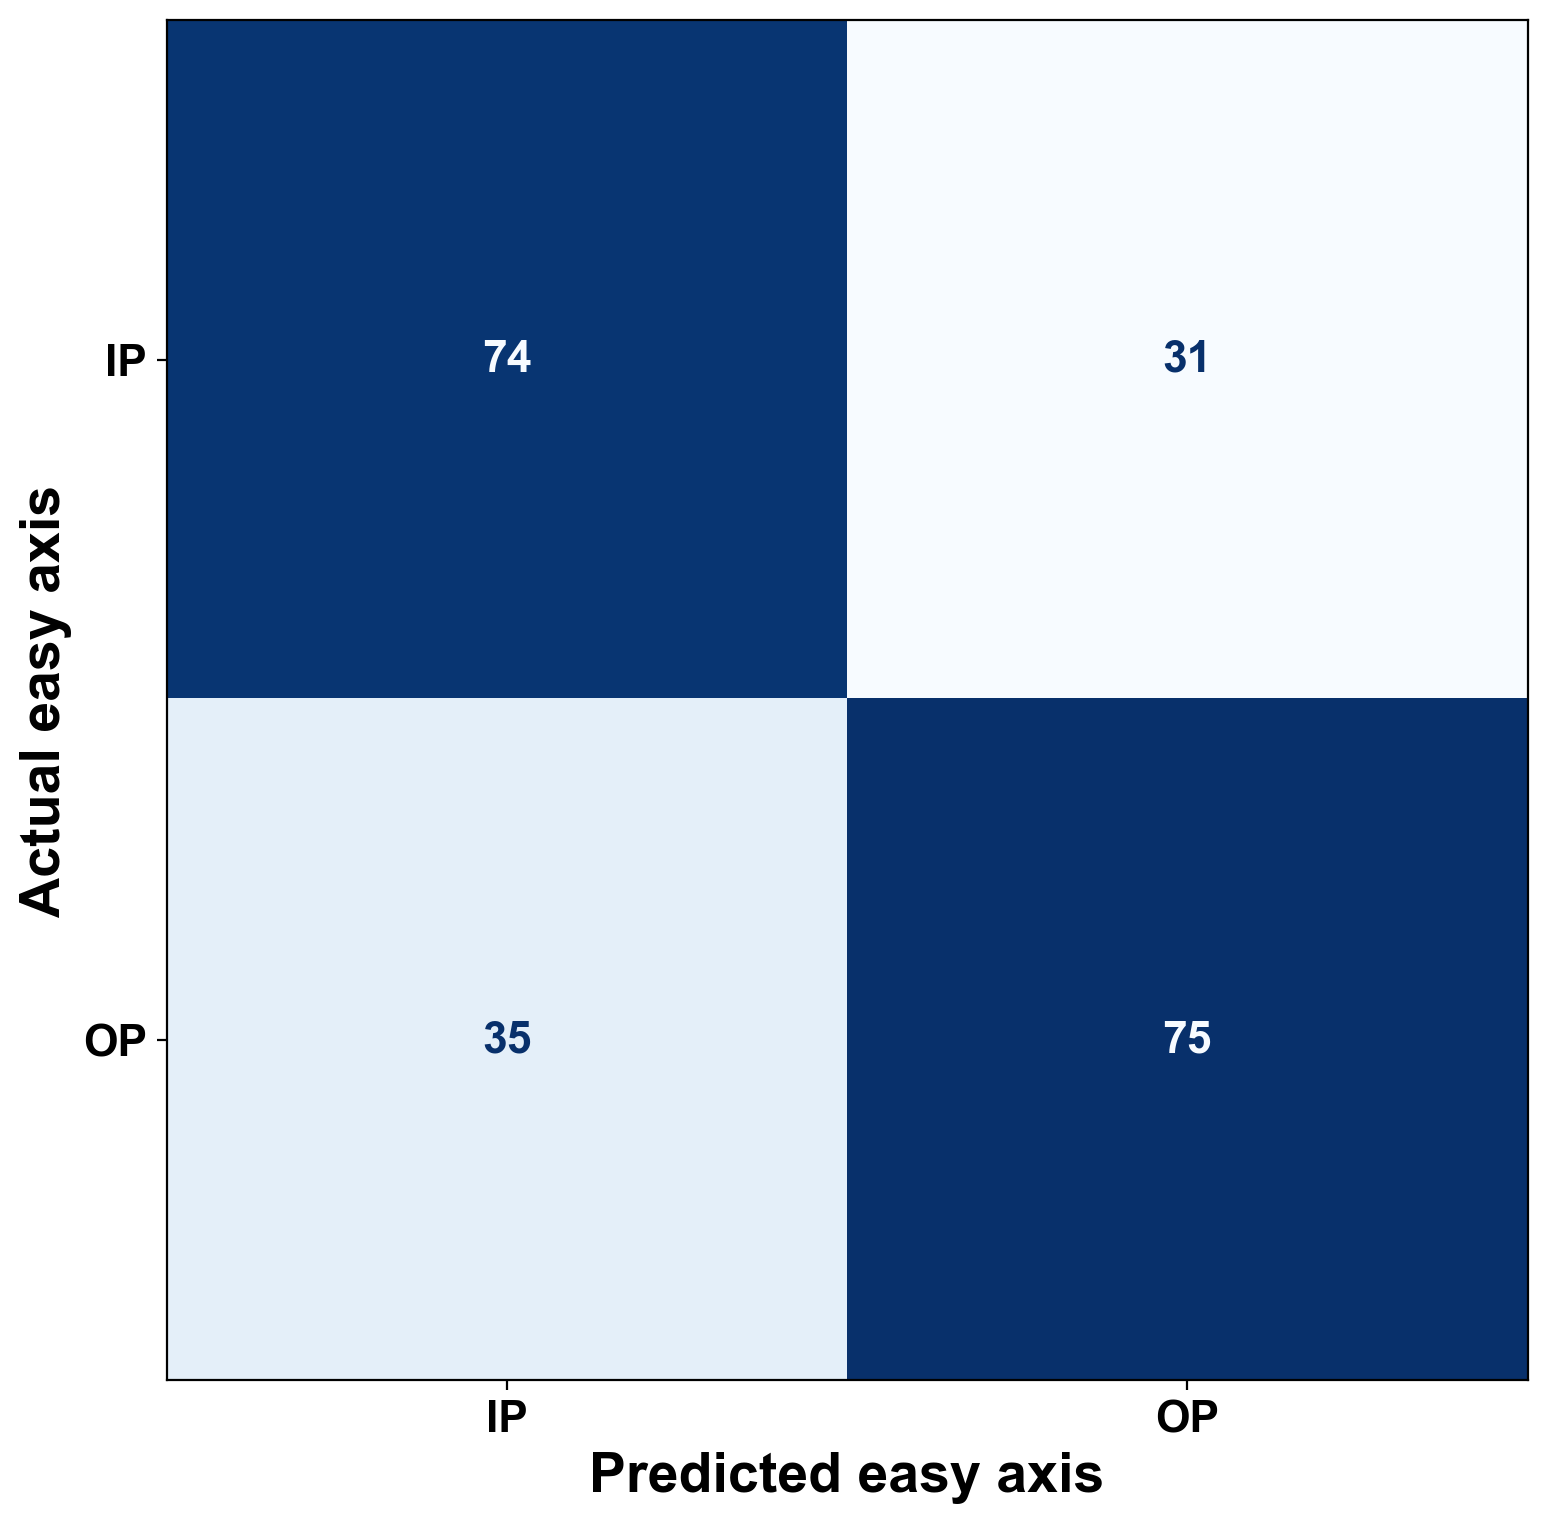

In [17]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['IP','OP'])
disp.plot(include_values=True, cmap=cmap, colorbar=colorbar)
plt.xlabel('Predicted easy axis', fontsize=20) #r'$T_{\mathrm{c}}$ (K)'
plt.ylabel('Actual easy axis', fontsize=20)
plt.tight_layout()

plt.savefig('confusion_matrix_MAE.png', dpi=300, bbox_inches='tight')

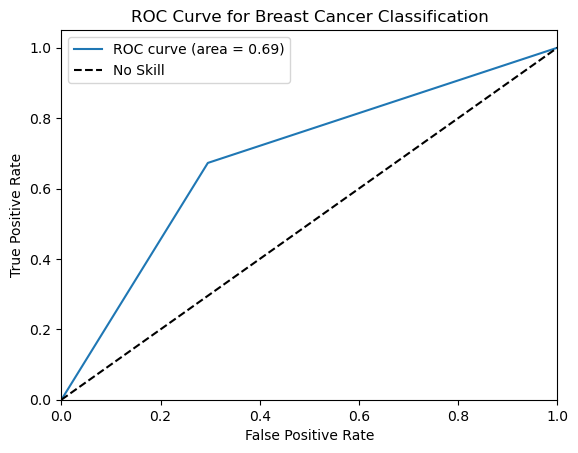

In [31]:
fpr, tpr, thresholds = roc_curve(test_y, predict_y) 
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Breast Cancer Classification')
plt.legend()
plt.show()

In [22]:
test_y

11      0
12      0
17      0
46      1
61      1
       ..
2097    0
2110    0
2122    0
2129    0
2147    0
Name: uniaxial, Length: 215, dtype: int64

In [23]:
import joblib

In [24]:
joblib.dump(model, "/home/huseyin.ucar/matminer/1-train-MAE/MAE_RF.joblib")

['/home/huseyin.ucar/matminer/1-train-MAE/MAE_RF.joblib']

In [25]:
model=joblib.load("/home/huseyin.ucar/matminer/1-train-MAE/MAE_RF.joblib")

In [26]:
model.predict(np.array(featurizers.featurize(df['structures'][1000])).reshape(1,-1))

array([1])

In [27]:
model

Pipeline(steps=[('imputer', SimpleImputer()),
                ('model',
                 RandomForestClassifier(max_depth=20, n_estimators=200,
                                        n_jobs=-1, random_state=0))])